# Jump diffusion coefficient from a VASP file

[Previously](./vasp_msd.html), we looked at obtaining accurate estimates for the mean-squared displacement with `kinisi`. 
Here, we show using the same class to evaluate the diffusion coefficient, using the `kinisi` [methodology](./methodology.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipp as sc
from kinisi.analyze import JumpDiffusionAnalyzer
from pymatgen.io.vasp import Xdatcar
np.random.seed(42)
rng = np.random.RandomState(42)

As wil the [previous example](./vasp_d.html), `params` dictionary will describe the details about the simulation.

In [2]:
params = {'specie': 'Li',
          'time_step': 2.0 * sc.Unit('fs'),
          'step_skip': 50 * sc.Unit('dimensionless'),
          'progress': False
          }

Again, we will add an additional key-value pair to the dictionary. 
First, we add the number of system particles.
The computation of the jump diffusion coefficient requires the mean-squared total displacement to be found. 
The MSTD is the displacement of the centre of mass of all relevant particles in the simulation, meaning there is just a single "atom" or system particle observed. 
We can improve the statistics on the computation of the jump diffusion coefficient by splitting the simulation into many smaller simulations and finding the MSTD of each. 
The `system_particles` parameter defines how many times the simulation should be split. 

In [3]:
params['system_particles']= 16

In [4]:
xd = Xdatcar('./example_XDATCAR.gz')
diff = JumpDiffusionAnalyzer.from_xdatcar(xd, **params)

Reading Trajectory: 100%|██████████| 140/140 [00:00<00:00, 9711.93it/s]


In the above cells, we parse and determine the uncertainty on the mean-squared displacement as a function of the timestep. 
We should visualise this, to check that we are observing diffusion in our material and to determine the timescale at which this diffusion begins. 

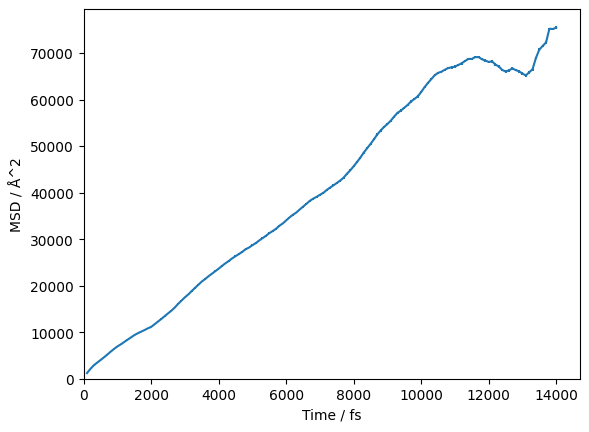

In [5]:
fig, ax = plt.subplots()

ax.errorbar(diff.dt.values, diff.mstd.values, np.sqrt(diff.mstd.values))
ax.set_xlabel(f'Time / {diff.dt.unit}')
ax.set_ylabel(f'MSD / {diff.mstd.unit}')
ax.set_xlim(0, None)
ax.set_ylim(0, None)
plt.show()

We can visualise this on a log-log scale, which helps to reveal the diffusive regime (the region where the gradient stops changing).

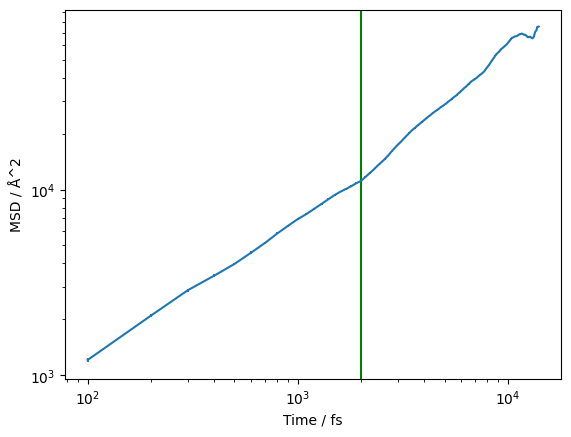

In [6]:
fix, ax = plt.subplots()

ax.errorbar(diff.dt.values, diff.mstd.values, np.sqrt(diff.mstd.values))
ax.axvline(2000, color='g')
ax.set_xlabel(f'Time / {diff.dt.unit}')
ax.set_ylabel(f'MSD / {diff.mstd.unit}')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

The green line at 4000 fs appears to be a reasonable estimate of the start of the diffusive regime. 
Therefore, we want to pass `4000 * sc.Units('fs')` as the argument to the diffusion analysis below. 
At this stage, we pass the `random_state` argument to ensure reproducibility. 

In [7]:
start_of_diffusion = 2000 * sc.Unit('fs')
diff.jump_diffusion(start_of_diffusion, progress=False, random_state=rng)

This method estimates the correlation matrix between the timesteps and uses posterior sampling to find the self-diffusion coefficient, $D*$ and intercept.
We can find the mean of the marginal posterior samples of $D*$: 

In [8]:
diff.D_J

<scipp.Variable> (samples: 3200)    float64         [cm^2/s]  [0.0723187, 0.0854984, ..., 0.10288, 0.0775051]

Or we can get all of the sampled values from one of these objects. 

In [9]:
diff.D_J.values

array([0.07231871, 0.08549837, 0.099929  , ..., 0.05488407, 0.10288036,
       0.07750513], shape=(3200,))

The same for the intercept can be found from `diff.intercept`. 
A histogram of the marginal posterior probability distribution for $D*$ can be plotted as shown below. 

Having completed the analysis, we can save the object for use later (such as downstream by a plotting script). 

These hidden cells exist to remove any existing `example.hdf` file on builiding.

In [10]:
!rm example.hdf

In [12]:
diff._to_hdf5('example.hdf')

Writing type '<class 'kinisi.samples.Samples'>' to HDF5 not implemented, skipping.
Writing type '<class 'kinisi.samples.Samples'>' to HDF5 not implemented, skipping.
Writing type '<class 'kinisi.samples.Samples'>' to HDF5 not implemented, skipping.


The data is saved in a HDF5 file format which helps us efficiently store our data. 
We can then load the data with the following class method. 

In [15]:
loaded_diff = JumpDiffusionAnalyzer._from_hdf5('example.hdf')

We can plot the data with the credible intervals from the $D$ and $D_{\text{offset}}$ distribution.

AttributeError: 'Diffusion' object has no attribute 'intercept'

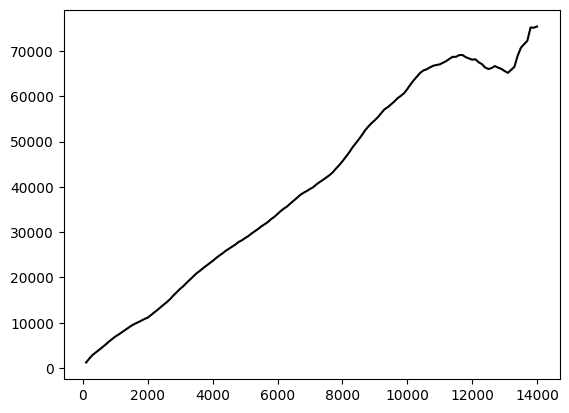

In [16]:
credible_intervals = [[16, 84], [2.5, 97.5], [0.15, 99.85]]
alpha = [0.6, 0.4, 0.2]

fig, ax = plt.subplots()
ax.plot(loaded_diff.dt.values, loaded_diff.mstd.values, 'k-')
for i, ci in enumerate(credible_intervals):
    ax.fill_between(loaded_diff.dt.values,
                     *np.percentile(loaded_diff.distributions, ci, axis=1),
                     alpha=alpha[i],
                     color='#0173B2',
                     lw=0)
ax.set_xlabel(f'Time / {diff.dt.unit}')
ax.set_ylabel(f'MSD / {diff.mstd.unit}')
ax.set_xlim(0, None)
ax.set_ylim(0, None)
plt.show()

Additionally, we can visualise the distribution of the diffusion coefficient that has been determined.

In [ ]:
fig, ax = plt.subplots()

ax.hist(loaded_diff.D_J.values, density=True)
ax.axvline(sc.mean(loaded_diff.D_J).value, c='k')
ax.set_xlabel(f'D* / {loaded_diff.D_J.unit}')
ax.set_ylabel(f'p(D*) / {(1 / loaded_diff.D_J.unit).unit}')
plt.show()

Or the joint probability distribution for the diffusion coefficient and intercept.

In [ ]:
from corner import corner

In [ ]:
corner(np.array([i.values for i in loaded_diff.flatchain.values()]).T, 
       labels=[' / '.join([k, str(v.unit)]) for k, v in loaded_diff.flatchain.items()])
plt.show()